# Data Preprocessing

In [91]:
import os
import json
import sqlite3

import pandas as pd
import matplotlib as plt
import numpy as np
import datetime

In [92]:
filepath = '../data/raw/user2/'

In [93]:
data = []
time_df = []

for filename in os.listdir(filepath):
    if filename == '.ipynb_checkpoints':
        continue
    cnx = sqlite3.connect(filepath + filename)
    df_string = pd.read_sql_query("SELECT * FROM COUNTERS_STRING_TIME_DATA", cnx)
    df_ull = pd.read_sql_query("SELECT * FROM COUNTERS_ULL_TIME_DATA", cnx)
    df_data = pd.concat([df_string, df_ull], ignore_index = True)
    start_val = pd.DataFrame({'MEASUREMENT_TIME': df_data.loc[0][0], 'ID_INPUT': 4, 'VALUE': 's0', 'PRIVATE_DATA': 0}, index =[0])
    df_data = pd.concat([start_val, df_data])
    data.append(pd.DataFrame(df_data))
    schema = pd.DataFrame(pd.read_sql_query("SELECT * FROM INPUTS", cnx))
    
    # get actual start time
    time_diff = pd.read_sql_query("SELECT * FROM DB_META_DATA", cnx)
    utc_open = pd.to_datetime(time_diff[time_diff['KEY'] == 'OPEN_TIME_UTC']['VALUE'].iloc[0])
    local_open = pd.to_datetime(time_diff[time_diff['KEY'] == 'OPEN_TIME_LOCAL']['VALUE'].iloc[0])
    time_difference = utc_open - local_open
    
    time_sub = df_data[df_data['ID_INPUT'] == 4].copy()
    time_sub['MEASUREMENT_TIME'] = pd.to_datetime(time_sub['MEASUREMENT_TIME'])
    time_sub['MEASUREMENT_TIME'] = time_sub['MEASUREMENT_TIME'] - time_difference
    time_sub['Time_Used'] = time_sub['MEASUREMENT_TIME'].diff().dt.total_seconds()
    time_sub['Time_Used'] = time_sub['Time_Used'].shift(periods = -1)
    time_sub = time_sub.drop(columns = ['PRIVATE_DATA', 'ID_INPUT'])
    time_df.append(time_sub)

In [628]:
df = pd.concat(data, ignore_index = True)

In [629]:
df['MEASUREMENT_TIME'] = pd.to_datetime(df['MEASUREMENT_TIME']) - time_difference
df['PRIVATE_DATA'] = df['PRIVATE_DATA'].astype(int)
#df['VALUE'] = df['VALUE'].str.lower()

In [630]:
df.dtypes

MEASUREMENT_TIME    datetime64[ns]
ID_INPUT                     int64
VALUE                       object
PRIVATE_DATA                 int32
dtype: object

In [631]:
df = df.sort_values(by = ['MEASUREMENT_TIME'], ignore_index = True)

In [632]:
df
# add "Missing String" to empty strings

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA
0,2023-01-19 12:06:06.562,4,s0,0
1,2023-01-19 12:06:06.562,9,701,0
2,2023-01-19 12:06:06.562,8,182,0
3,2023-01-19 12:06:06.562,7,1175,0
4,2023-01-19 12:06:06.562,6,182,0
...,...,...,...,...
29600,2023-02-07 23:05:36.701,10,0,0
29601,2023-02-07 23:05:36.701,3,esrv.exe,0
29602,2023-02-07 23:05:36.701,4,VsDebugConsole.exe,0
29603,2023-02-07 23:05:36.701,1,9096,0


In [633]:
if filepath == '../data/raw/user1/':
    df.to_csv('../data/temp/dataUser1.csv')
elif filepath == '../data/raw/user2/':
    df.to_csv('../data/temp/datauser2.csv')

# Exploratory Data Analysis (EDA)

In [634]:
shape = df.shape
print("Number of data points collected so far: " + str(shape[0]))

Number of data points collected so far: 29605


In [635]:
schema[['ID_INPUT', 'INPUT_NAME', 'INPUT_DESCRIPTION']]

,ID_INPUT,INPUT_NAME,INPUT_DESCRIPTION
0,0,FOREGROUND-WIND(0),Foreground Window Root ID
1,1,FOREGROUND-WIND(1),Foreground Window Process ID
2,2,FOREGROUND-WIND(2),Foreground Window Thread ID
3,3,FOREGROUND-WIND(3),Foreground Window Name
4,4,FOREGROUND-WIND(4),Foreground Window Image Name
5,5,FOREGROUND-WIND(5),Foreground Window Class Name
6,6,FOREGROUND-WIND(6),Window Upper Left X Coordinate
7,7,FOREGROUND-WIND(7),Window Lower Right X Coordinate
8,8,FOREGROUND-WIND(8),Window Upper Left Y Coordinate
9,9,FOREGROUND-WIND(9),Window Lower Right Y Coordinate


In [636]:
df.dtypes

MEASUREMENT_TIME    datetime64[ns]
ID_INPUT                     int64
VALUE                       object
PRIVATE_DATA                 int32
dtype: object

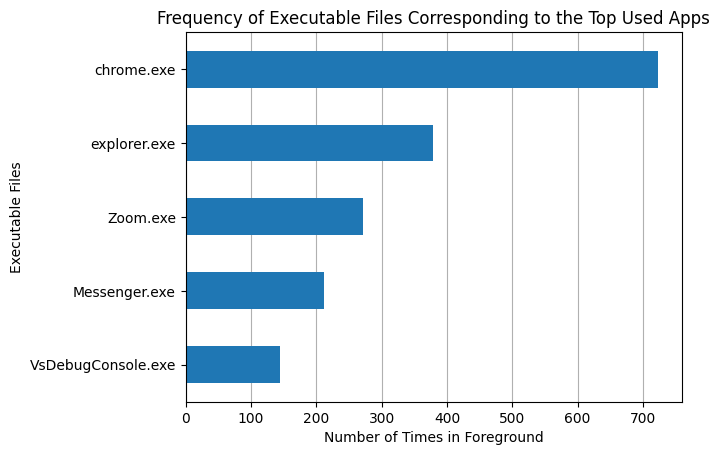

In [637]:
plot = df[df['ID_INPUT'] == 4]['VALUE'].value_counts()[:5].plot.barh(x = 'index', y = 'VALUE')
plot.set_axisbelow(True)
plot.set_xlabel('Number of Times in Foreground')
plot.set_ylabel('Executable Files')
plot.set_title('Frequency of Executable Files Corresponding to the Top Used Apps')
plot.invert_yaxis()
plt.pyplot.grid(axis = 'x')
plt.pyplot.show()

In [638]:
df[df['ID_INPUT'] == 3]['VALUE'].unique()[:5]
#unable to open process is when we use command prompt as an adminstrator

array(['esrv.exe', 'Foreground - Microsoft Visual Studio',
       'How to Configure a C/C++ Project in VS - Google Docs - Google Chrome',
       'Messenger', 'sdk'], dtype=object)

In [639]:
df['MEASUREMENT_TIME'].min()

Timestamp('2023-01-19 12:06:06.562000')

In [640]:
df['MEASUREMENT_TIME'].max()

Timestamp('2023-02-07 23:05:36.701000')

In [641]:
df[df['ID_INPUT'] == 10]['VALUE'].unique()

array([0], dtype=object)

In [642]:
df.shape[0]/12 # number of unique entries

2467.0833333333335

In [643]:
tmp = df[df.ID_INPUT == 4]

In [644]:
tmp.VALUE.unique()

array(['s0', 'VsDebugConsole.exe', 'devenv.exe', 'chrome.exe',
       'Messenger.exe', 'explorer.exe', 'Teams.exe', 'SearchHost.exe',
       'Unable To Open Process', 'python-3.11.1-amd64.exe',
       'ShellExperienceHost.exe', 'Git-2.39.1-64-bit.tmp', 'cmd.exe',
       'CredentialUIBroker.exe', 'ApplicationFrameHost.exe',
       'DB Browser for SQLite.exe', 'Spotify.exe', 'msedge.exe',
       'MoNotificationUx.exe', 'Zoom.exe', 'Docker Desktop.exe',
       'OneDrive.exe', 'winzip64.exe', 'ScreenClippingHost.exe',
       'PickerHost.exe', 'msiexec.exe', 'rundll32.exe', 'conhost.exe',
       'LockApp.exe', 'msteams.exe', 'Acrobat.exe', 'Widgets.exe',
       'Installer.exe', 'EXCEL.EXE', 'Notepad.exe', 'OpenWith.exe',
       'vlc.exe'], dtype=object)

In [645]:
len(tmp.VALUE.unique())

37

In [646]:
tmp.groupby('VALUE').count().sort_values(by="ID_INPUT", ascending=False) # executable can have the extension "tmp"

,MEASUREMENT_TIME,ID_INPUT,PRIVATE_DATA
VALUE,,,
chrome.exe,723,723,723
explorer.exe,379,379,379
Zoom.exe,271,271,271
Messenger.exe,211,211,211
VsDebugConsole.exe,145,145,145
DB Browser for SQLite.exe,121,121,121
Teams.exe,112,112,112
ApplicationFrameHost.exe,100,100,100
cmd.exe,85,85,85


In [647]:
len(df.PRIVATE_DATA.unique())

1

In [648]:
df = df.assign(date = df["MEASUREMENT_TIME"].astype(str).apply(lambda x: x[:10]))

In [649]:
df.groupby('date').count()

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA
date,,,,
2023-01-19,4733,4733,4733,4733
2023-01-20,4712,4712,4712,4712
2023-01-21,361,361,361,361
2023-01-22,1527,1527,1527,1527
2023-01-23,1925,1925,1925,1925
2023-01-24,1682,1682,1682,1682
2023-01-25,1911,1911,1911,1911
2023-01-26,1297,1297,1297,1297
2023-01-27,2089,2089,2089,2089


In [650]:
tab_app = df[df.ID_INPUT == 3]
tab_app.groupby('VALUE').count()

,MEASUREMENT_TIME,ID_INPUT,PRIVATE_DATA,date
VALUE,,,,
,86,86,86,86
(no title) | Microsoft Teams,1,1,1,1
.ipynb file is not opening on windows - Google Search - Google Chrome,1,1,1,1
"16 Top-Rated Ski Resorts on the East Coast, 2023 | PlanetWare - Google Chrome",1,1,1,1
2️⃣ Quarter 2 Project | DSC 180AB - Google Chrome,4,4,4,4
...,...,...,...,...
uninstall apps windows 10 - Google Search - Google Chrome,1,1,1,1
what is a blob in python - Google Search - Google Chrome,4,4,4,4
when do i get Shell_TrayWnd returned - Google Search - Google Chrome,1,1,1,1


In [651]:
tab_app['VALUE'][:20]

10                                              esrv.exe
24                  Foreground - Microsoft Visual Studio
35                                              esrv.exe
37     How to Configure a C/C++ Project in VS - Googl...
50                                              esrv.exe
66                                             Messenger
77                                              esrv.exe
86                                                   sdk
106                                             esrv.exe
113    Public -- 2022-2023 (CCG DCA UCSD-HDSI Capston...
124                                             esrv.exe
142    How to Configure a C/C++ Project in VS - Googl...
146                                               Search
168                        Administrator: Command Prompt
178    Installation - pip documentation v22.3.1 - Goo...
192                        Administrator: Command Prompt
196    Installation - pip documentation v22.3.1 - Goo...
215                            

# Exploring Time Usage

In [94]:
all_time_df = pd.concat(time_df, ignore_index = True)
all_time_df = all_time_df.fillna(0)

if filepath == 'data/':
    all_time_df.to_csv('timeuser1.csv')
elif filepath == 'data user2/':
    all_time_df.to_csv('timeuser2.csv')

In [95]:
all_time_df['MEASUREMENT_TIME'].min()

Timestamp('2023-01-19 12:06:06.562000')

In [96]:
all_time_df['MEASUREMENT_TIME'].max()

Timestamp('2023-02-07 23:05:36.701000')

In [97]:
top_times = all_time_df.sort_values(by='Time_Used', ascending=False, inplace=False)
top_times[:50]

,MEASUREMENT_TIME,VALUE,Time_Used
344,2023-02-04 14:00:00.296,chrome.exe,21954.172
661,2023-01-24 13:00:22.469,chrome.exe,19982.078
533,2023-02-03 17:26:31.819,ApplicationFrameHost.exe,12109.678
1544,2023-01-23 10:55:05.496,explorer.exe,11530.199
690,2023-01-30 16:29:09.846,ApplicationFrameHost.exe,8935.665
909,2023-01-25 16:37:02.316,explorer.exe,8611.865
66,2023-01-31 16:48:18.343,ApplicationFrameHost.exe,8448.389
273,2023-01-22 07:39:14.564,chrome.exe,8370.358
694,2023-01-30 19:17:15.011,chrome.exe,7864.547
889,2023-02-07 20:23:06.170,ApplicationFrameHost.exe,7571.495


In [98]:
total_times = all_time_df.groupby('VALUE')['Time_Used'].sum().sort_values(ascending = False)
total_times[:10]

VALUE
chrome.exe                   258326.559
ApplicationFrameHost.exe      70762.114
explorer.exe                  25619.498
Messenger.exe                 20727.388
Teams.exe                     19955.858
Zoom.exe                      12125.265
msedge.exe                     9895.755
Spotify.exe                    7952.927
DB Browser for SQLite.exe      3794.490
devenv.exe                     2794.692
Name: Time_Used, dtype: float64

In [99]:
top_10_apps = all_time_df[all_time_df['VALUE'].isin(total_times[:10].index)]

<AxesSubplot: xlabel='Time_Used', ylabel='VALUE'>

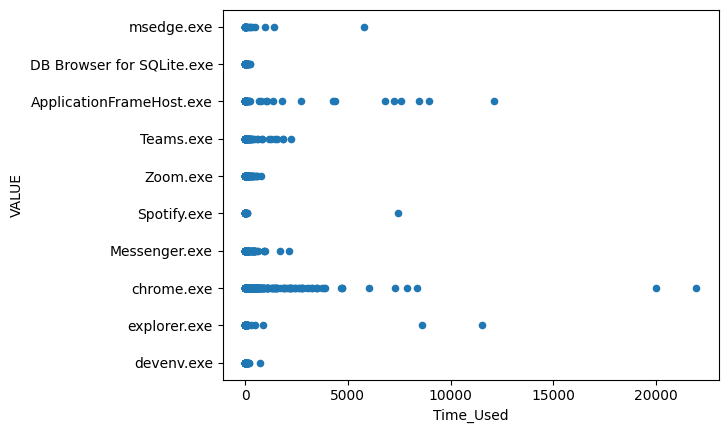

In [100]:
top_10_apps.plot.scatter(y = 'VALUE', x = 'Time_Used')
#plt.pyplot.xticks(rotation=90)
#plt.pyplot.show()

In [101]:
all_time_df['Hour'] = all_time_df['MEASUREMENT_TIME'].dt.hour
all_time_df

,MEASUREMENT_TIME,VALUE,Time_Used,Hour
0,2023-01-31 14:25:21.928,s0,0.000,14
1,2023-01-31 14:25:21.928,VsDebugConsole.exe,5.046,14
2,2023-01-31 14:25:26.974,devenv.exe,2.017,14
3,2023-01-31 14:25:28.991,explorer.exe,10.337,14
4,2023-01-31 14:25:39.328,cmd.exe,7.050,14
...,...,...,...,...
2496,2023-01-23 09:48:54.468,Teams.exe,85.674,9
2497,2023-01-23 09:50:20.142,explorer.exe,8.065,9
2498,2023-01-23 09:50:28.207,DB Browser for SQLite.exe,21.142,9
2499,2023-01-23 09:50:49.349,explorer.exe,3.012,9


In [102]:
#all_time_df['Time_Used'] = all_time_df['Time_Used'] / 60 / 60
#all_time_df

In [103]:
time_spent = all_time_df.groupby('VALUE')['Time_Used'].sum().sort_values(ascending = False)
time_spent

VALUE
chrome.exe                   258326.559
ApplicationFrameHost.exe      70762.114
explorer.exe                  25619.498
Messenger.exe                 20727.388
Teams.exe                     19955.858
Zoom.exe                      12125.265
msedge.exe                     9895.755
Spotify.exe                    7952.927
DB Browser for SQLite.exe      3794.490
devenv.exe                     2794.692
vlc.exe                        2625.795
cmd.exe                        2300.791
Unable To Open Process         1612.387
MoNotificationUx.exe           1262.082
VsDebugConsole.exe              440.046
ScreenClippingHost.exe          324.622
SearchHost.exe                  227.529
ShellExperienceHost.exe          97.829
LockApp.exe                      57.668
Acrobat.exe                      49.332
EXCEL.EXE                        43.466
CredentialUIBroker.exe           39.453
msiexec.exe                      38.355
msteams.exe                      35.410
PickerHost.exe                   2

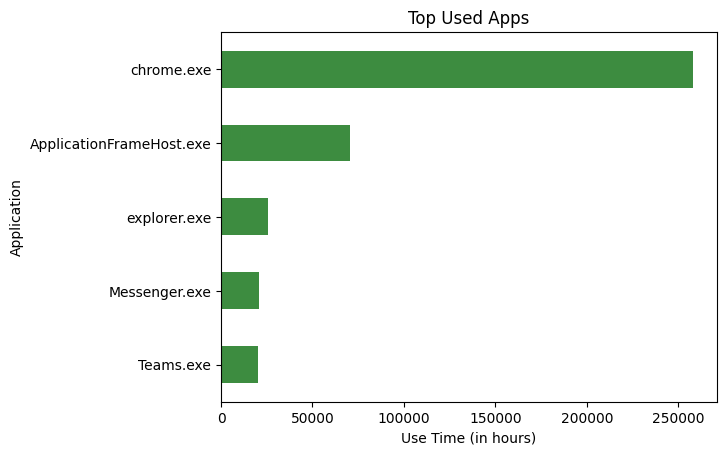

In [104]:
#Plot top 5 apps with the most time spent on for the whole DataFrame
plot = time_spent[:5].plot.barh(color = '#3D8C40')
plot.set_axisbelow(True)
plot.set_xlabel('Use Time (in hours)')
plot.set_ylabel('Application')
plot.set_title('Top Used Apps')
plot.invert_yaxis()

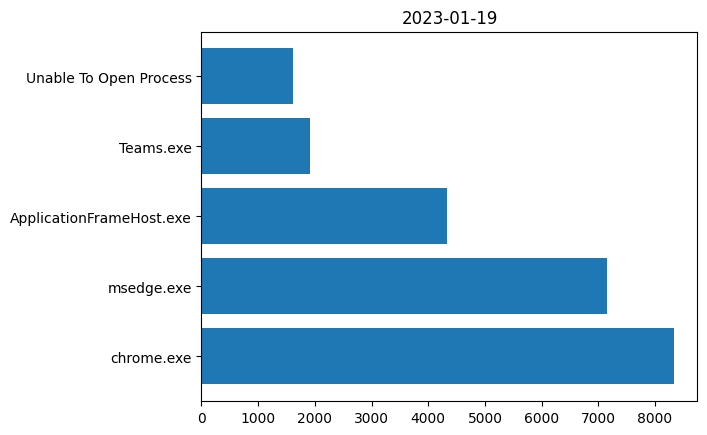

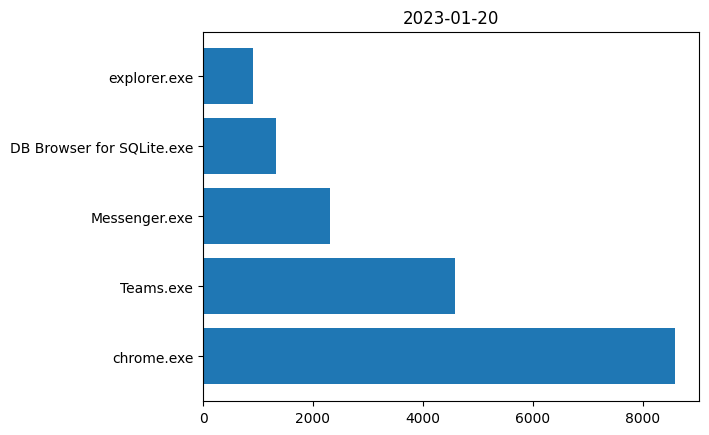

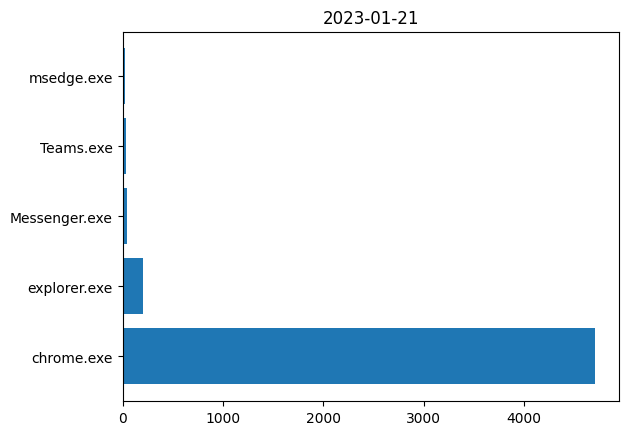

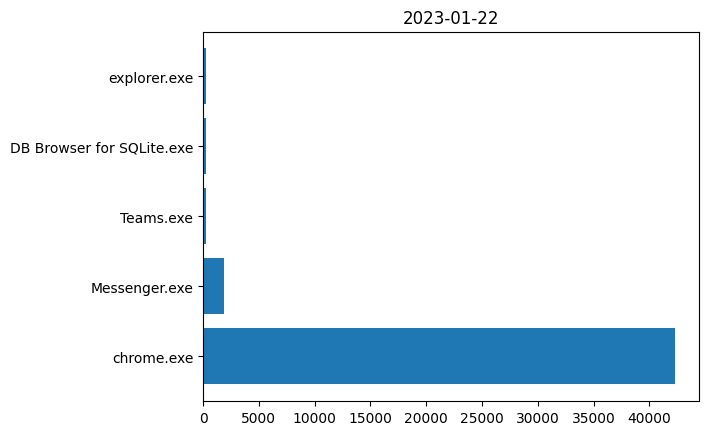

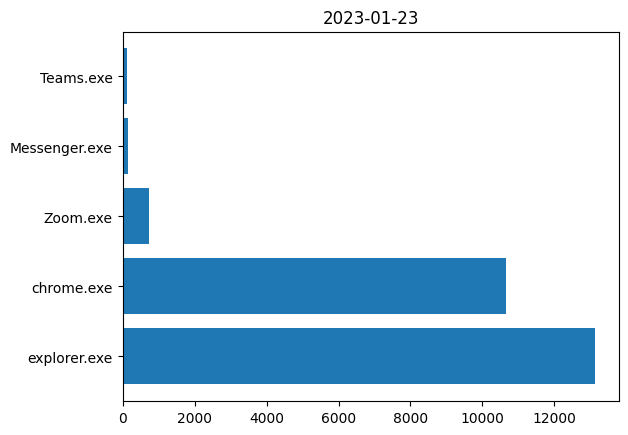

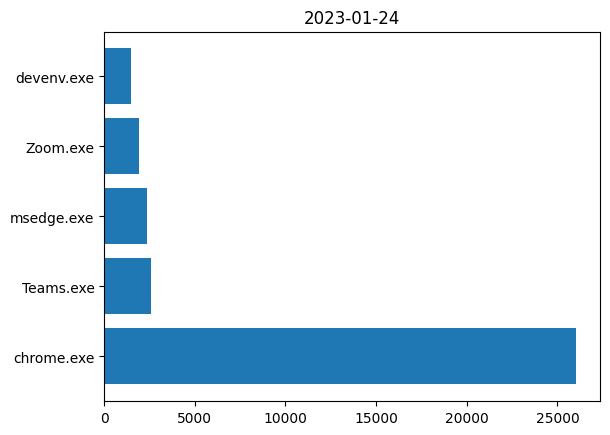

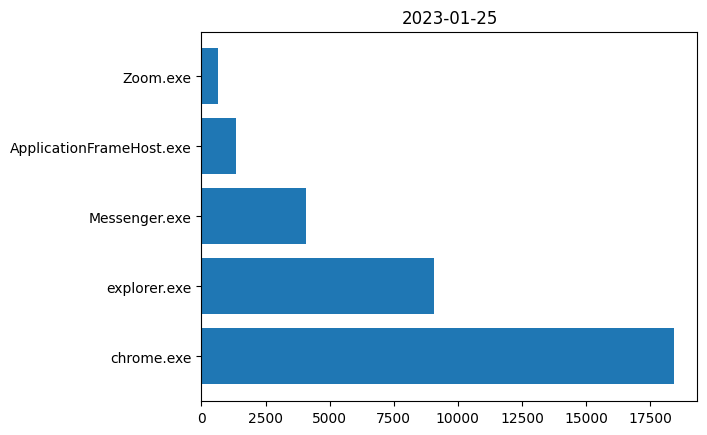

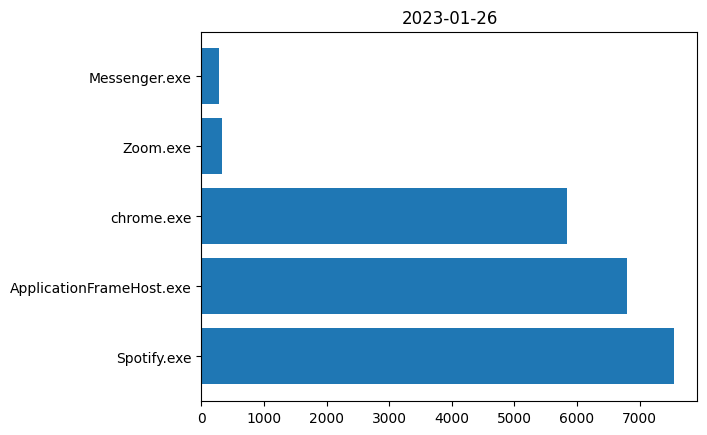

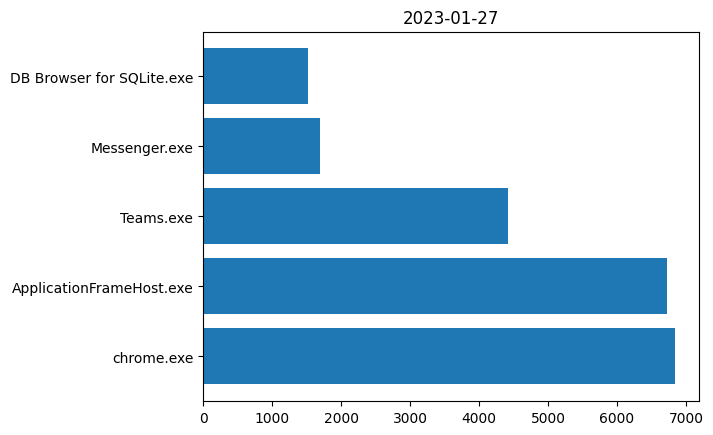

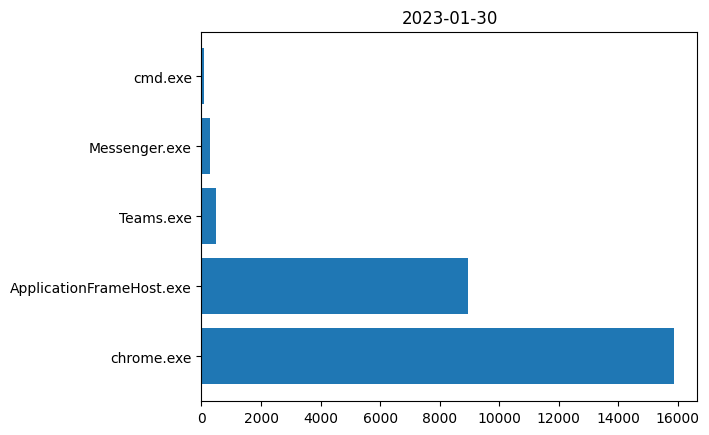

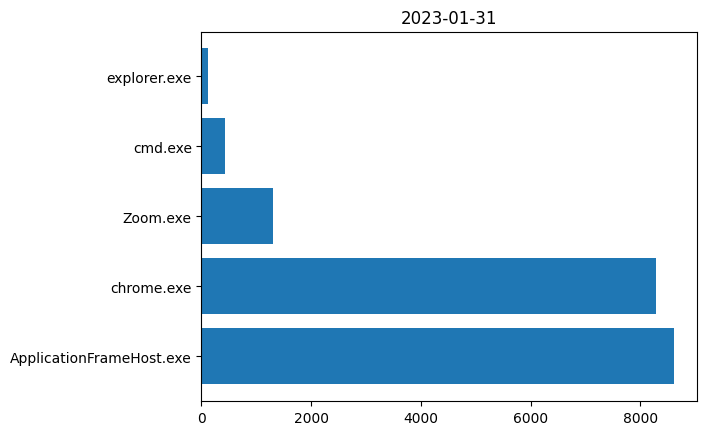

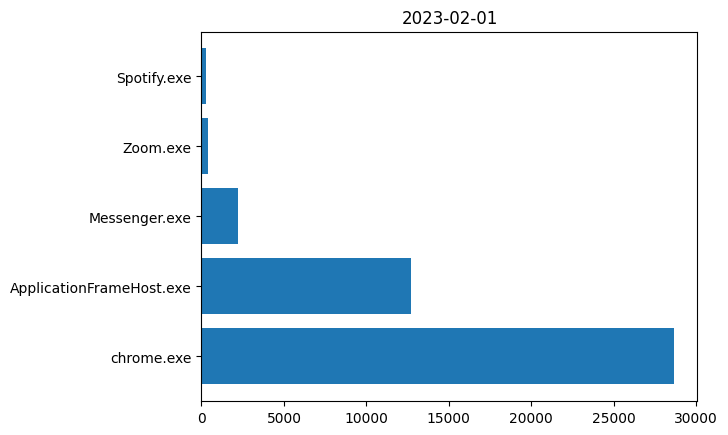

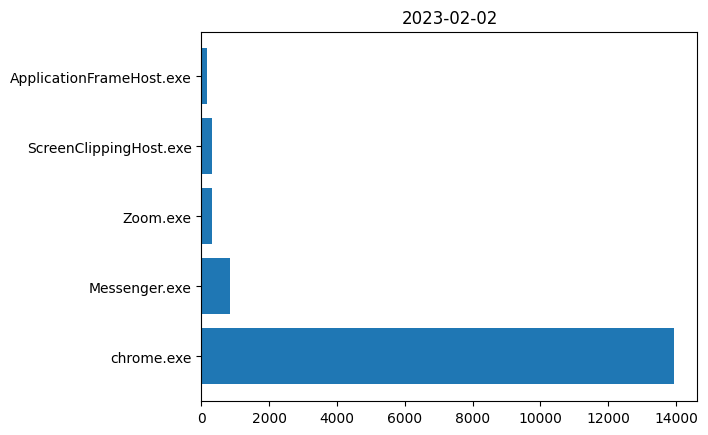

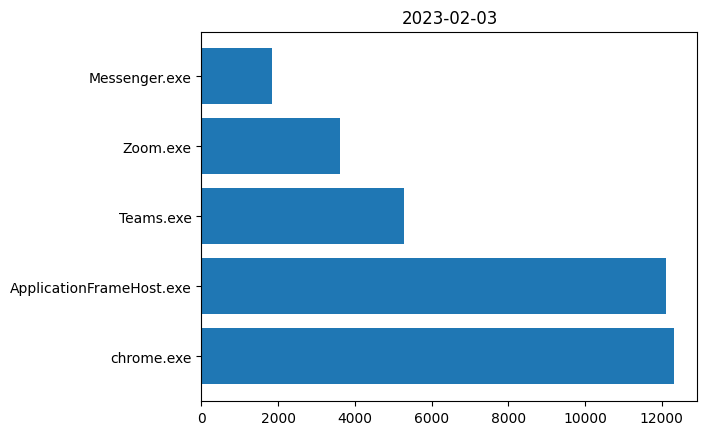

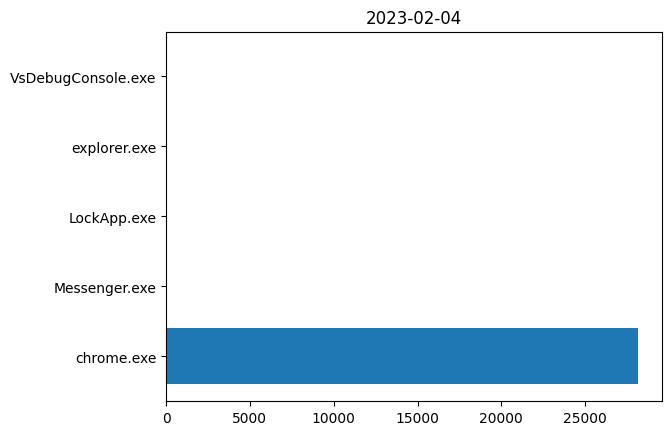

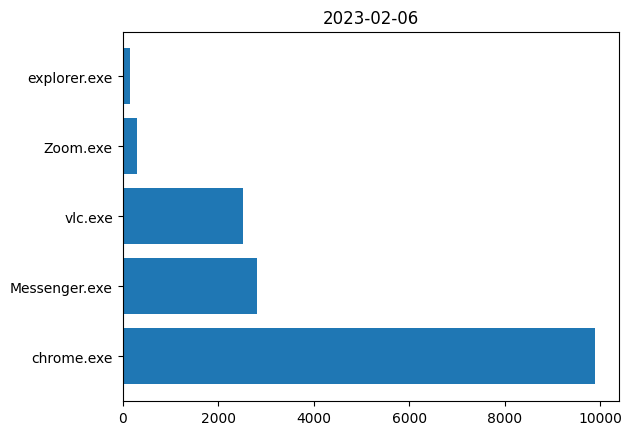

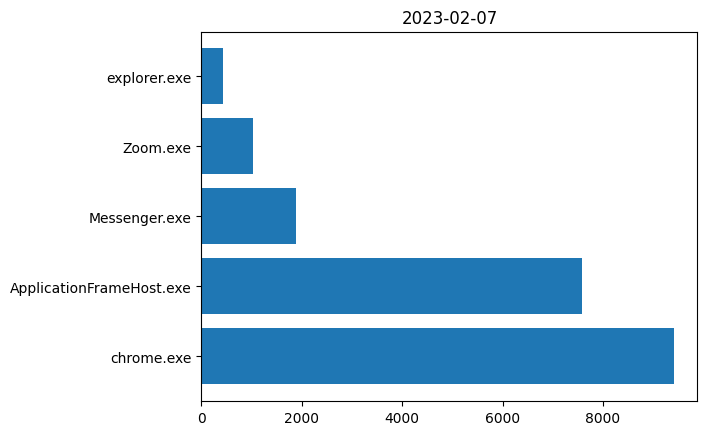

In [105]:
#Top 5 apps per day for the User
all_time_df= all_time_df.assign(Date = all_time_df['MEASUREMENT_TIME'].apply(lambda x: x.strftime("%Y-%m-%d")))
time_per_date = all_time_df.groupby("Date").apply(lambda x: x.groupby("VALUE")["Time_Used"].sum()).sort_values(ascending = False)
val = pd.DataFrame(time_per_date).reset_index(level=1, inplace=False)
grouped = val.groupby("Date")

for key, item in grouped:
    item.sort_values(by='Time_Used', ascending=False, inplace=True)
    item = item.head(5)
    plt.pyplot.barh(item['VALUE'], item['Time_Used'])
    plt.pyplot.title(f'{key}')
    plt.pyplot.show()


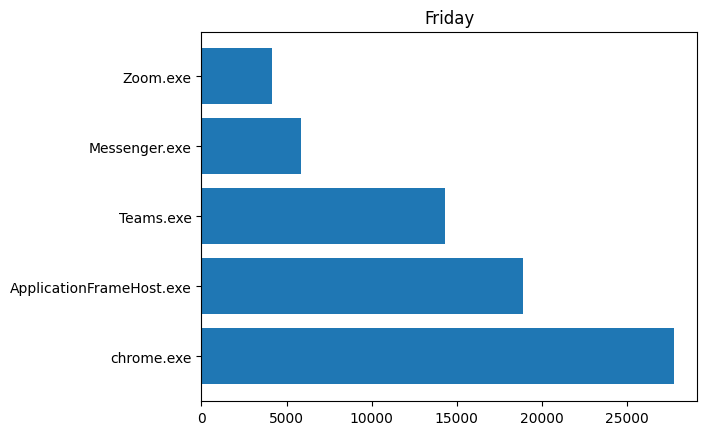

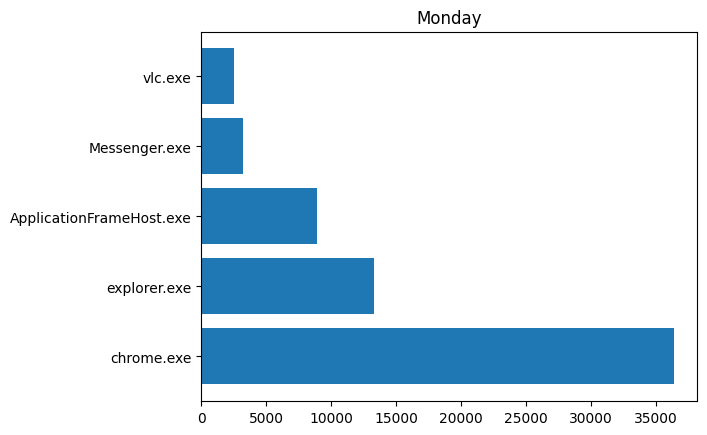

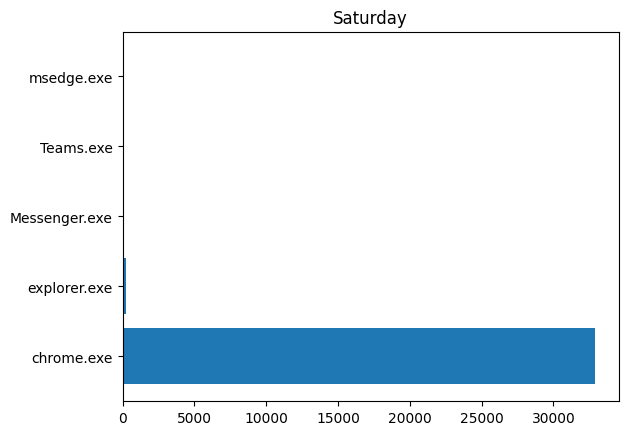

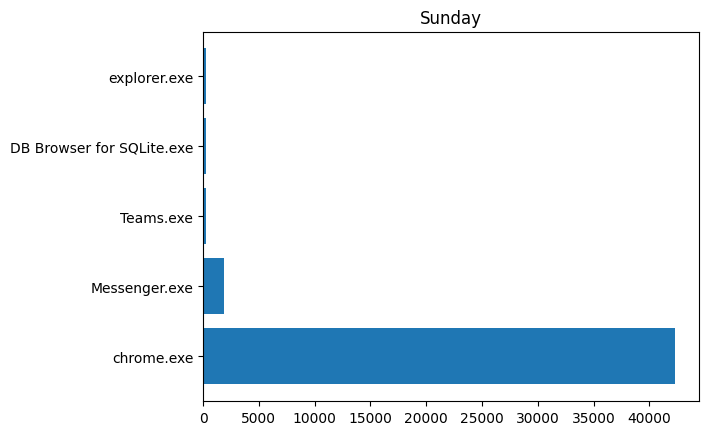

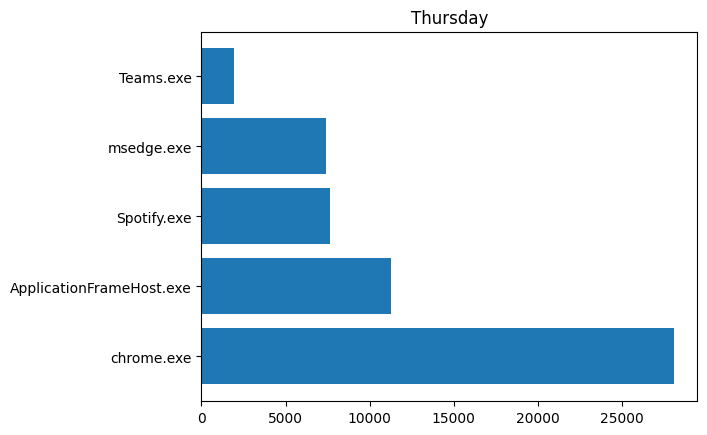

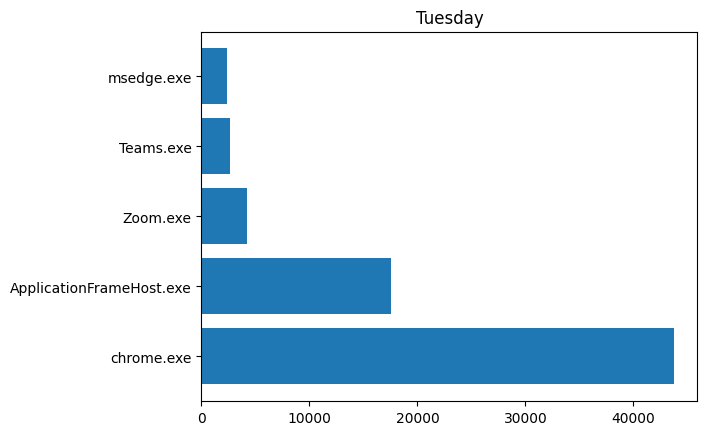

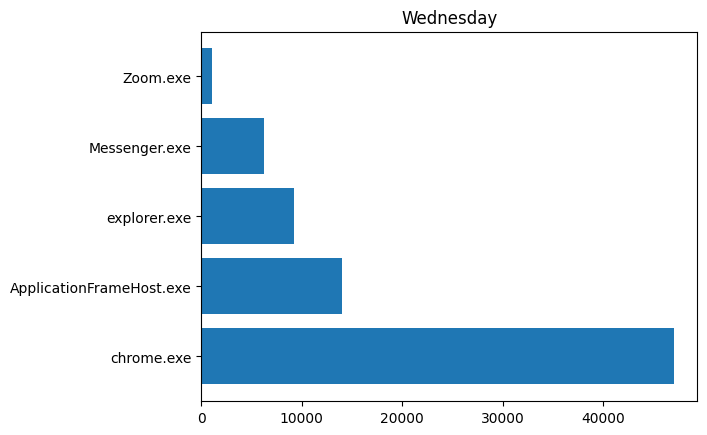

In [106]:
all_time_df['Day'] = all_time_df['MEASUREMENT_TIME'].dt.day_name()
time_per_day = all_time_df.groupby("Day").apply(lambda x: x.groupby("VALUE")["Time_Used"].sum()).sort_values(ascending = False)
val = pd.DataFrame(time_per_day).reset_index(level=1, inplace=False)
grouped = val.groupby("Day")

for key, item in grouped:
    item.sort_values(by='Time_Used', ascending=False, inplace=True)
    item = item.head(5)
    plt.pyplot.barh(item['VALUE'], item['Time_Used'])
    plt.pyplot.title(f'{key}')
    plt.pyplot.show()


# Cleaning Up for RNN

In [107]:
all_time_df['Minute'] = all_time_df['MEASUREMENT_TIME'].dt.minute
all_time_df['Day'] = all_time_df['MEASUREMENT_TIME'].dt.day
all_time_df['Month'] = all_time_df['MEASUREMENT_TIME'].dt.month
all_time_df['Day_Week'] = all_time_df['MEASUREMENT_TIME'].dt.day_name()
all_time_df = all_time_df.assign(Week_Year = all_time_df['MEASUREMENT_TIME'].apply(lambda x: x.strftime("%W")))
all_time_df = all_time_df.assign(Week_Day = all_time_df['Week_Year'] + '_' + all_time_df['Day_Week'])

In [108]:
all_time_df
#Time_Used = time used in hours
#Hour = the hour of the day that it started

,MEASUREMENT_TIME,VALUE,Time_Used,Hour,Date,Day,Minute,Month,Day_Week,Week_Year,Week_Day
0,2023-01-31 14:25:21.928,s0,0.000,14,2023-01-31,31,25,1,Tuesday,05,05_Tuesday
1,2023-01-31 14:25:21.928,VsDebugConsole.exe,5.046,14,2023-01-31,31,25,1,Tuesday,05,05_Tuesday
2,2023-01-31 14:25:26.974,devenv.exe,2.017,14,2023-01-31,31,25,1,Tuesday,05,05_Tuesday
3,2023-01-31 14:25:28.991,explorer.exe,10.337,14,2023-01-31,31,25,1,Tuesday,05,05_Tuesday
4,2023-01-31 14:25:39.328,cmd.exe,7.050,14,2023-01-31,31,25,1,Tuesday,05,05_Tuesday
...,...,...,...,...,...,...,...,...,...,...,...
2496,2023-01-23 09:48:54.468,Teams.exe,85.674,9,2023-01-23,23,48,1,Monday,04,04_Monday
2497,2023-01-23 09:50:20.142,explorer.exe,8.065,9,2023-01-23,23,50,1,Monday,04,04_Monday
2498,2023-01-23 09:50:28.207,DB Browser for SQLite.exe,21.142,9,2023-01-23,23,50,1,Monday,04,04_Monday
2499,2023-01-23 09:50:49.349,explorer.exe,3.012,9,2023-01-23,23,50,1,Monday,04,04_Monday


### Table for Subtask 1

In [109]:
time_per_week_day = all_time_df.copy()
time_per_week_day['Time_Used'] = time_per_week_day['Time_Used'] / 60 / 60
time_per_week_day = time_per_week_day.groupby("Week_Day").apply(lambda x: x.groupby("VALUE")["Time_Used"].sum())
time_per_week_day = pd.DataFrame(time_per_week_day).reset_index(level=1, inplace=False)
df_pivot = time_per_week_day.pivot_table(index = 'Week_Day', columns='VALUE', values='Time_Used').fillna(0)
df_pivot

VALUE,Acrobat.exe,ApplicationFrameHost.exe,CredentialUIBroker.exe,DB Browser for SQLite.exe,Docker Desktop.exe,EXCEL.EXE,Git-2.39.1-64-bit.tmp,Installer.exe,LockApp.exe,Messenger.exe,...,devenv.exe,explorer.exe,msedge.exe,msiexec.exe,msteams.exe,python-3.11.1-amd64.exe,rundll32.exe,s0,vlc.exe,winzip64.exe
Week_Day,,,,,,,,,,,,,,,,,,,,,
03_Friday,0.000000,0.020221,0.000000,0.366891,0.001125,0.000000,0.000000,0.000000,0.000000,0.639291,...,0.227526,0.251576,0.029981,0.010654,0.000000,0.000000,0.00059,0.0,0.000000,0.00084
03_Saturday,0.000000,0.001963,0.000000,0.001400,0.000000,0.000000,0.000000,0.000000,0.000000,0.010903,...,0.000556,0.056239,0.005602,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.00000
03_Sunday,0.013703,0.004776,0.000000,0.067408,0.000000,0.000000,0.000000,0.000000,0.001960,0.527224,...,0.001399,0.063004,0.000000,0.000000,0.009836,0.000000,0.00000,0.0,0.000000,0.00000
03_Thursday,0.000000,1.201377,0.010959,0.111530,0.000000,0.000000,0.000281,0.000000,0.000000,0.102976,...,0.059069,0.089719,1.987549,0.000000,0.000000,0.001959,0.00000,0.0,0.000000,0.00000
04_Friday,0.000000,1.868229,0.000000,0.423460,0.000000,0.000000,0.000000,0.000000,0.000000,0.471129,...,0.001958,0.084119,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.00000
04_Monday,0.000000,0.000000,0.000000,0.008670,0.001116,0.000000,0.000000,0.001679,0.001685,0.041150,...,0.030766,3.646355,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.00000
04_Thursday,0.000000,1.889301,0.000000,0.000000,0.000000,0.010120,0.000000,0.000000,0.000000,0.076887,...,0.000281,0.056278,0.063634,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.00000
04_Tuesday,0.000000,0.384927,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001989,0.000000,...,0.407519,0.042830,0.658695,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.00000
04_Wednesday,0.000000,0.369916,0.000000,0.072989,0.000000,0.001954,0.000000,0.000000,0.001676,1.130474,...,0.000837,2.518008,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.00000


### Tables for Subtask 2

In [110]:
# need to fix logic in here 
from datetime import timedelta, date

def date_range(start, end):
    dates = []
    delta = end - start
    for i in range(delta.days + 2):
        date = start + timedelta(days=i)
        date = date.strftime("%Y-%m-%d")
        dates.append(date)
    return dates

In [111]:
all_columns = [x for x in range(0,24)]
all_columns.append('Total_Usage')
all_index = date_range(all_time_df['MEASUREMENT_TIME'].min(), all_time_df['MEASUREMENT_TIME'].max())
apps = {}
for app_name in all_time_df['VALUE'].unique():
    if app_name == 's0':
        continue
    app = all_time_df[all_time_df['VALUE'] == app_name]
    app = app.reset_index()
    zero_data = np.zeros(shape=(len(all_index),len(all_columns)))
    app_df = pd.DataFrame(zero_data, index = all_index, columns = all_columns)
    for x in range(len(app)):
        timestamp = app.loc[x]["MEASUREMENT_TIME"]
        usage = app.loc[x]['Time_Used']
        end_timestamp = timestamp + datetime.timedelta(seconds = usage)
        start_hour = app.loc[x]['Hour']
        end_hour = int(end_timestamp.strftime("%H"))
        date = app.loc[x]['Date']
        if start_hour == end_hour:
            app_df.loc[date][start_hour] += usage
            app_df.loc[date]['Total_Usage'] += usage
        else:
            remaining_seconds = 3600 - (app.loc[x]['Minute'] * 60 + int(timestamp.strftime("%S")))
            app_df.loc[date][start_hour] += remaining_seconds
            app_df.loc[date]['Total_Usage'] += remaining_seconds
            overflow = usage - remaining_seconds
            curr_hour = start_hour + 1
            while overflow > 3600:
                if curr_hour > 23:
                    date = app.loc[x]["MEASUREMENT_TIME"] + datetime.timedelta(days = 1)
                    date = date.strftime("%Y-%m-%d")
                    curr_hour = 0
                app_df.loc[date][curr_hour] += 3600
                app_df.loc[date]['Total_Usage'] += 3600
                curr_hour = curr_hour + 1
                overflow -= 3600

            if curr_hour > 23:
                date = app.loc[x]["MEASUREMENT_TIME"] + datetime.timedelta(days = 1)
                date = date.strftime("%Y-%m-%d")
                curr_hour = 0
            app_df.loc[date][curr_hour] += overflow
            app_df.loc[date]['Total_Usage'] += overflow
            
    apps[app_name] = app_df.reset_index(drop = True)

In [22]:
#apps['chrome.exe'].to_csv('chrome_time.csv')

In [129]:
top_5 = time_spent[:5].index
app_dfs = []
top_5_app_dfs = []
enumerated_app_dfs = []
app_dict = {app_name: index for index, app_name in enumerate(apps.keys())}
for app_name, df in apps.items():
    df['Application'] = app_name
    app_dfs.append(df)
    if app_name in top_5:
        top_5_app_dfs.append(df)
    df['Application'] = app_dict[app_name]
    enumerated_app_dfs.append(df)
    
    
combined_df = pd.concat(app_dfs)
top_5_combined_df = pd.concat(top_5_app_dfs)
enumerated_combined_df = pd.concat(enumerated_app_dfs)

all_app_df = pd.get_dummies(combined_df, columns = ['Application'])
top_5_app_df = pd.get_dummies(top_5_combined_df, columns = ['Application'])

In [138]:
all_app_df = all_app_df.sort_index().reset_index(drop = True)
all_app_df.to_csv('../data/out/all_app_time.csv')

In [139]:
top_5_app_df = top_5_app_df.sort_index().reset_index(drop = True)
top_5_app_df.to_csv('../data/out/top_5_app_time.csv')

In [140]:
enumerated_combined_df = enumerated_combined_df.sort_index().reset_index(drop = True)
enumerated_combined_df.to_csv('../data/out/enumerated_app_time.csv')